In [1]:
import pickle
import numpy as np
import heatmaps
# from animated_plots import animateFFTRange, animateRangeHeatmap, animateDopplerRangeHeatmap, animateAzimuthRangeHeatmap
from fourier import rangeFFT, angleFFT, dopplerFFT
from params import PARAMS
from raw_signal import RadarData, plot_signal
import matplotlib.pyplot as plt
from time import sleep as sleep
from IPython.display import display, clear_output

Slope 166000000000000.0
Bandwith 3984.0 GHz
Minimum Frame Periodicity: 11.904000000000002 ms
Chirps Per Frame: 384
Num Range Bins: 256
Range Resolution: 0.03762455547188755 m
Max Unambiguous Range: 8.668697580722892 m
Num Doppler Bins: 128
Doppler Resolution: 0.20986815216173832 m/s
Max Doppler: 13.431561738351252 m/s
Num Azimuth Bins: 64
Num Elevation Bins: 32


In [2]:
# Load data from file
data = pickle.load(open('data/openradar_25-01-23_QMUL-MCR.dat', 'rb'))
# Configure playback mode
config = data['config']
PARAMS.set_playback_mode(config)
# Read main parameters
rdata = RadarData(device='IWR6843ISK-ODS',
                  tx=PARAMS.TX_ANTENNAS,
                  rx=PARAMS.RX_ANTENNAS,
                  loops=PARAMS.CHIRP_LOOPS,
                  samples=PARAMS.ADC_SAMPLES)

# Get data frame
frames = data['data']
# Choose frame
adc_data = frames[2]
# Set RadarData raw_data
rdata.raw_data = adc_data
# Access data separated by Rx and Tx antennas
v_array = rdata.separated_vx_data
## Doppler FFT
[dFFT, dBins, rBins] = dopplerFFT(v_array)

# fig, ax = plt.subplots()
# c = ax.pcolormesh(rBins[8*4:60*8], dBins, dFFT[:,8*4:60*8])
# fig.colorbar(c, ax=ax)
# ax.set_title('Doppler-Range Heatmap')
# ax.set_xlabel('Range (m)')
# ax.set_ylabel('Doppler (m/s)')
# plt.show()

In [ ]:
## Doppler FFT
[dFFT, dBins, rBins] = dopplerFFT(v_array)

fig, ax = plt.subplots()
c = ax.pcolormesh([rBins[8*4:60*5]], dBins[128:128+256], dFFT[128:128+256,8*4:60*5])
# fig.colorbar(c, ax=ax)
ax.set_title('Velocity-Range Heatmap')
ax.set_xlabel('Range (m)')
ax.set_ylabel('Velocity (m/s)')
for n in range(np.size(frames,0)):
    # Choose frame
    adc_data = frames[n]
    # Set RadarData raw_data
    rdata.raw_data = adc_data
    # Access data separated by Rx and Tx antennas
    v_array = rdata.separated_vx_data
    ## Doppler FFT
    [dFFT, dBins, rBins] = dopplerFFT(v_array)
    c.set_array(dFFT[128:256+128,8*4:60*5])
    # plt.show()
    ax.set_title('Velocity-Range Heatmap ' + '-- Frame #' + str(n+1))
    # ax.subtitle()
    fig.savefig('images/doppler'+str(n+1),dpi=600)
    display(fig)
    clear_output(wait = True)
    plt.pause(0.1)


In [ ]:
from scipy.interpolate import CubicSpline
## 1D RANGE FFT and radar cube
[RC, rFFT, rBins] = rangeFFT(v_array[100,:,:],rdata.device)
# The range profile can be extracted from this as
rProf = np.mean(abs(rFFT[:,0:128]),axis=0)[8:]
# Cubic Spline
f = CubicSpline(rBins[8:128],rProf, bc_type='natural')
xnew= np.linspace(rBins[8],rBins[128],num=1000)
ynew = f(xnew)
# yinterp = np.interp(xvals, rBins[8:128], np.mean(abs(rFFT[:,0:128]),axis=0)[8:])
plt.plot(xnew,ynew)
plt.xlabel('Range (m)')
plt.grid(visible=True)
# plt.show()
plt.savefig('images/rProfile.png',dpi=600)


In [ ]:
fig, ax = plt.subplots()
line1 = ax.plot(0, 0)


ax.set_title('Range Profile')
ax.set_xlabel('Range (m)')
ax.grid(visible=True)


for n in range(np.size(frames,0)):
    # Choose frame
    adc_data = frames[n]
    # Set RadarData raw_data
    rdata.raw_data = adc_data
    # Access data separated by Rx and Tx antennas
    v_array = rdata.separated_vx_data
    ## 1D RANGE FFT and radar cube
    [RC, rFFT, rBins] = rangeFFT(v_array[100,:,:],rdata.device)
    # The range profile can be extracted from this as
    rProf = np.mean(abs(rFFT[:,0:128]),axis=0)[8:]
    # Cubic Spline
    f = CubicSpline(rBins[8:128],rProf, bc_type='natural')
    xnew= np.linspace(rBins[8],rBins[128],num=1000)
    ynew = f(xnew)

    ax.cla()
    ax.set_title('Range Profile')
    ax.set_xlabel('Range (m)')
    ax.grid(visible=True)
    ax.set_ylim(0,130000)
    ax.plot(xnew,ynew)
    ax.legend(['Frame #' + str(n+1)])
    display(fig)
    clear_output(wait = True)
    # fig.savefig('images/rProf'+str(n+1),dpi=600)
    plt.pause(0.1)

In [ ]:
fig, ax = plt.subplots()
line1 = ax.plot(0, 0)


ax.set_title('Range Profile')
ax.set_xlabel('Range (m)')
ax.grid(visible=True)

adc_data = frames[10]
# Set RadarData raw_data
rdata.raw_data = adc_data
# Access data separated by Rx and Tx antennas
v_array = rdata.separated_vx_data

for n in range(np.size(v_array,0)):
    ## 1D RANGE FFT and radar cube
    [RC, rFFT, rBins] = rangeFFT(v_array[n,:,:],rdata.device)
    # The range profile can be extracted from this as
    rProf = np.mean(abs(rFFT[:,0:128]),axis=0)[8:]
    # Cubic Spline
    f = CubicSpline(rBins[8:128],rProf, bc_type='natural')
    xnew= np.linspace(rBins[8],rBins[128],num=1000)
    ynew = f(xnew)

    ax.cla()
    # ax.set_label = 
    ax.set_ylim(0,130000)
    ax.plot(xnew,ynew)
    ax.legend(['Chirp #' + str(n+1)])
    ax.grid(visible=True)

    display(fig)
    clear_output(wait = True)
    # fig.savefig('images/rProfSlowTime'+str(n+1),dpi=600)
    plt.pause(0.1)

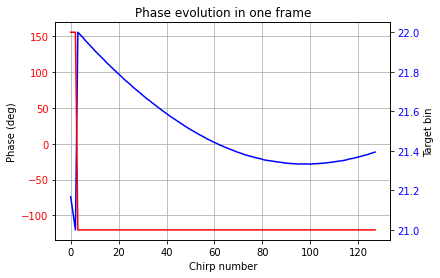

In [54]:
fig, ax1 = plt.subplots()

ax1.set_title('Phase evolution in one frame')
ax1.set_xlabel('Chirp number')
ax1.set_ylabel('Phase (deg)')
ax1.grid(visible=True)
ax1.tick_params(axis='y',labelcolor='red')

ax2 = ax1.twinx()
ax2.set_ylabel('Target bin')
ax2.tick_params(axis ='y', labelcolor = 'blue') 

adc_data = frames[10]
# Set RadarData raw_data
rdata.raw_data = adc_data
# Access data separated by Rx and Tx antennas
v_array = rdata.separated_vx_data
## 1D RANGE FFT and radar cube
[RC, rFFT, rBins] = rangeFFT(v_array[0,:,:],rdata.device)
rMaxLoc = np.argmax(abs(rFFT[0,:128]))
# plt.plot(abs(rFFT[0,:128]))
# plt.show()
rPhase = np.zeros((1,np.size(v_array,0)))
rm = np.zeros((1,np.size(v_array,0)))

for n in range(np.size(v_array,0)):
    ## 1D RANGE FFT and radar cube
    [RC, rFFT, rBins] = rangeFFT(v_array[n,:,:],rdata.device)
    # The range profile can be extracted from this as
    rPhase[0,n] = np.angle(rFFT[0,rMaxLoc],deg=True)
    rm[0,n] = np.argmax(abs(rFFT[0,:128]))
ax2.plot(rm.T,color='red')
ax1.plot(rPhase.T,color='blue')
plt.show()
fig.savefig('images/phaseEvolution',dpi=600)


In [ ]:
## 2D AZIMUTH & ELEVATION FFTs
[aFFT, eFFT, aBins, eBins] = angleFFT(RC)

In [ ]:
# Polar heatmaps
# heatmaps.plotAzimuthRangeHeatmap(rBins[:80],aBins[1:],aFFT[1:,:80])
# heatmaps.plotElevationRangeHeatmap(rBins[:80],eBins[1:],eFFT[1:,:80])
# Cartesian HEATMAP
from fourier import matlabMultip
# heatmaps.plotXYheatmap(rBins[:60],aBins[1:],10*np.log10(aFFT[1:,:60]))
ax = plt.axes()
X = matlabMultip(rBins[:60].T, np.sin(aBins[1:]*np.pi/180))
Y = matlabMultip(rBins[:60].T, np.cos(aBins[1:]*np.pi/180))
# ax.plot_surface(X, Y, 10*np.log10(aFFT[1:,:60]).T, cmap=plt.cm.jet,linewidth=0 )
ax.pcolormesh(X,Y,(aFFT[1:,:60]).T)
# ax.view_init(90, 90)

In [ ]:
## Doppler FFT
[dFFT, dBins, rBins] = dopplerFFT(v_array)

heatmaps.plotDopplerRangeHeatmap(rBins[:60],dBins,abs(dFFT[:,:60]))